# setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk

import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")


def learning_curve(history):
    hist = history.history
    train_acc, val_acc, train_loss, val_loss =\
        hist["acc"], hist["val_acc"], hist["loss"], hist["val_loss"]

    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(range(len(train_acc)), train_acc, label = "train_acc")
    ax2.plot(range(len(train_acc)), val_acc, label = "val_acc")
    ax1.plot(range(len(train_acc)), train_loss, label = "train_loss")
    ax1.plot(range(len(train_acc)), val_loss, label = "val_loss")

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Acc')

    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()

# load data & preprocessing

In [3]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

import pathlib

data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("\nDirectory names:", dirnames)

fnames = os.listdir(data_dir / "comp.graphics")
print("\nNumber of files in comp.graphics:", len(fnames))
print("\nSome example filenames:", fnames[:5])

Number of directories: 20

Directory names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Number of files in comp.graphics: 1000

Some example filenames: ['37261', '37913', '37914', '37915', '37916']


In [5]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):   # subject별 디렉토리 순회
    class_names.append(dirname)         
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)               # subject 디렉터리 내 모든 문서파일명
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:                       # 개별 subject 내부 파일 순회
        fpath = dirpath / fname                # 개별 파일 경로
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")            # 줄별로 분리
        lines = lines[10:]                     # header 날리기
        content = "\n".join(lines)             # 다시 분리된 line들을 다시 합치기
        samples.append(content)                # 전처리한 text를 sample목록에 추가
        labels.append(class_index)
    class_index += 1

print("\nClasses:", class_names)
print("\nNumber of samples:", len(samples))

Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.os.ms-windows.misc, 1000 files found
Processing comp.sys.ibm.pc.hardware, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.motorcycles, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.electronics, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.mideast, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found

Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.h

In [6]:
from sklearn.model_selection import train_test_split

train_samples, val_samples, train_labels, val_labels =\
    train_test_split(samples, labels, test_size = 0.2, random_state = 2021)

In [48]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

# make a vocab

In [10]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# 빈도순으로 20000개의 단어만 고려, output 시퀀스 길이 200
vectorizer = TextVectorization(max_tokens=20000, 
                               output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [11]:
# get dictionary mapping words to indices
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# load word2vec
... 100차원짜리 word2vec 구하기가 쉽지않아 300으로 비교해야될듯

In [37]:
from gensim.models import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format("C:/Users/user/study/GoogleNews-vectors-negative300.bin.gz", 
                                             binary=True)
print(word2vec.vectors.shape)

(3000000, 300)


In [38]:
# test
word2vec.most_similar('learning')

[('teaching', 0.6601868271827698),
 ('learn', 0.6365275382995605),
 ('Learning', 0.6208058595657349),
 ('reteaching', 0.580967366695404),
 ('learner_centered', 0.5738571882247925),
 ('emergent_literacy', 0.5706572532653809),
 ('teach', 0.5704741477966309),
 ('kinesthetic_learning', 0.5656599402427673),
 ('learners', 0.5508513450622559),
 ('learing', 0.5438815355300903)]

In [41]:
def get_vector(word):
    if word in word2vec:
        return word2vec[word]
    else:
        return None

In [43]:
# prepare embedding matrix
num_tokens = len(voc)
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = get_vector(word) 
    if embedding_vector is not None:
        # word2vec에 없는 단어들은 100차원 원소들이 모두 0인상태로 남음
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(np.shape(embedding_matrix))

Converted 15814 words (4186 misses)
(20000, 300)


# model

In [44]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [45]:
# set Embedding layer
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # freezing
    trainable=False
)

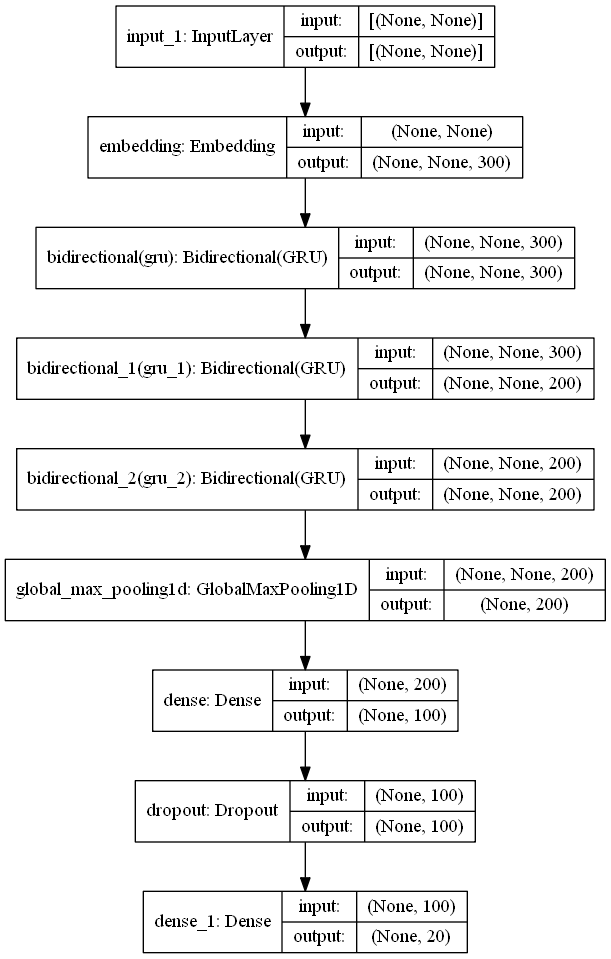

In [46]:
int_sequences_input = keras.Input(shape = (None, ), dtype = "int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(150, return_sequences = True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(100, return_sequences = True,
                                     dropout = 0.2, recurrent_dropout = 0.2))(x)
x = layers.Bidirectional(layers.GRU(100, return_sequences = True,
                                     dropout = 0.2, recurrent_dropout = 0.2))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(100, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
preds = layers.Dense(len(class_names), activation = "softmax")(x)
bigru = keras.Model(int_sequences_input, preds)

bigru.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

plot_model(bigru, show_shapes = True)

In [ ]:
bigru_hist = bigru.fit(x_train, y_train, batch_size=128, epochs=20, 
                         validation_data=(x_val, y_val), verbose = 1)
learning_curve(bigru_hist)
print("last 5 acc mean :",np.mean(bigru_hist.history['val_acc'][-5:]))

Epoch 1/20
125/125 [==============================] - 1993s 16s/step - loss: 2.4697 - acc: 0.2082 - val_loss: 1.4794 - val_acc: 0.4915
Epoch 2/20
125/125 [==============================] - 2106s 17s/step - loss: 1.4562 - acc: 0.5030 - val_loss: 1.2752 - val_acc: 0.5655
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 1.2307 - acc: 0.5890 